<a href="https://colab.research.google.com/github/vittorio21bargero/ml-1dl034-public-assignments/blob/main/IML_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to machine learning - Lab 2

Please read the comments in each code block. The comments provide instructions and there are places that you are expected to fill in your own code. In order to get familiar with scikit learn's library you are expected to read the documentation. In the comments for the code links have been provided.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io as skio
from tqdm import tqdm_notebook as tqdm

In [ ]:
# The wget command downloads the image we will work with today.
# If it does not work, you can download it manually (make sure it is in the right folder) and
# rename it as "talos.jpg" without the quotes.
!wget -nc https://upload.wikimedia.org/wikipedia/commons/thumb/5/50/Vaso_di_Talos_particolare.JPG/1920px-Vaso_di_Talos_particolare.JPG
!mv 1920px-Vaso_di_Talos_particolare.JPG talos.jpg

--2020-02-21 07:28:10--  https://upload.wikimedia.org/wikipedia/commons/thumb/5/50/Vaso_di_Talos_particolare.JPG/1920px-Vaso_di_Talos_particolare.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 398515 (389K) [image/jpeg]
Saving to: ‘1920px-Vaso_di_Talos_particolare.JPG’

1920px-Vaso_di_Talo 100%[===================>] 389.17K  --.-KB/s    in 0.09s   

2020-02-21 07:28:10 (4.20 MB/s) - ‘1920px-Vaso_di_Talos_particolare.JPG’ saved [398515/398515]



# Part 1 - K-Means clustering

K-means clustering is an unsupervised method for finding clusters. There can be any amount of clusters and there can by any dimensions. Let's name the number of clusters K, and the number of dimensions D.

One special case of K-means is image compression, this will be the topic of the first part of this lab.

Let's start with an image:

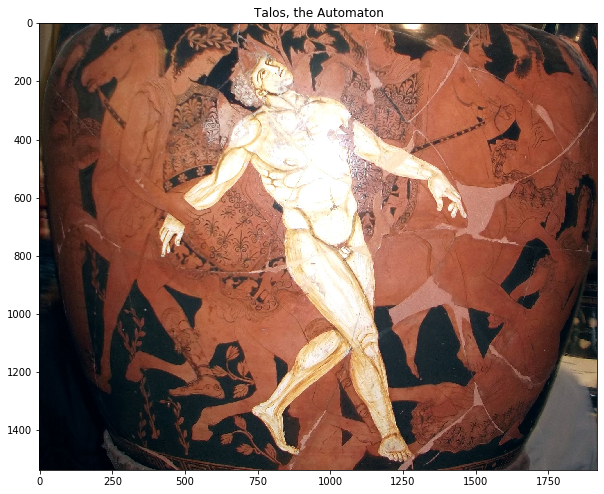

In [ ]:
# Loading the image
# Documentation: https://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imread
# [CODE HERE] Load the image in a variable called "image"

# [/CODE HERE]

# Standardization of the image (values go from the range 0-255 to 0-1)
# Documentation: https://scikit-image.org/docs/dev/api/skimage.html#skimage.img_as_float32
# [CODE HERE] Standardise the image

# [/CODE HERE]
assert image.max() - 1.0 < 1e-7, "The image must be standardized."

# Plotting the image
plt.figure(figsize=(10, 10))
plt.title("Talos, the Automaton")
plt.imshow(image)
plt.show()

In [ ]:
print(f"Image width   : {image.shape[0]}")
print(f"Image height  : {image.shape[1]}")
print(f"Image channels: {image.shape[2]}")
print(f"Image size    : {np.prod(image.shape)}")

Image width   : 1537
Image height  : 1920
Image channels: 3
Image size    : 8853120


The image above has a width of 1537 pixels, a height of 1920 pixels and 3 different channels (RGB, Red/Green/Blue). When the image is not compressed, each of the values are coded as a byte, so that the full image weighs: $1537 \times 1920 \times 3 = 8853120$ bytes, or approximately 8.9Mb.

One way of reducing the size of the image is by reducing the number of colors used. Right now, the RGB channels cost 24 bits for each pixels, so that each pixel can reproduce 24 million different colors. That is too much, especially for a boring image such as talos.jpg.

One way of compressing is by choosing a palette of K colors. If we chose a palette of size 16, there could only be 16 different colors in the image, but 16 can be coded in 4 bits only instead of 24. Thus, we could reach a compression factor of 83%.

But first, let's reshape the data to be able to display the RGB data in 3-dimensions.

In [ ]:
# This steps reshape the image in the format (N, D) for N points in D dimensions.
# D will always be 3 since we will only deal with RGB images today.
pixels = image.reshape(-1, 3)
print("Pixels array shape                   :", pixels.shape)
# There are 2 951 040 pixels in 3 dimensions, which is A LOT!
# If you have too much data, algorithms will be slow, and displaying the data can take forever (literally).
# So let's keep 0.1% of them (in other words randomly discard 99.9%)
# Documentation: https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.rand.html

# [CODE HERE] Create a variable "keep" of size pixels.shape[0] that contains a random binary mask with 0.1% of True's.

# [/CODE HERE]
assert keep.dtype == bool, "keep must be containing booleans"
assert len(keep) == pixels.shape[0], "keep has the wrong shape, it should be pixels.shape[0]"
assert (np.unique(keep) == [False, True]).all(), "keep must only contain True/False values"
# Now the smaller dataset is named pixels_small
pixels_small = pixels[keep]
print("Pixels array shape (after discarding):", pixels_small.shape)
print(f"Reduction in size                    : {1-pixels_small.shape[0]/pixels.shape[0]:.1%}")

Pixels array shape                   : (2951040, 3)
True
Pixels array shape (after discarding): (3024, 3)
Reduction in size                    : 99.9%


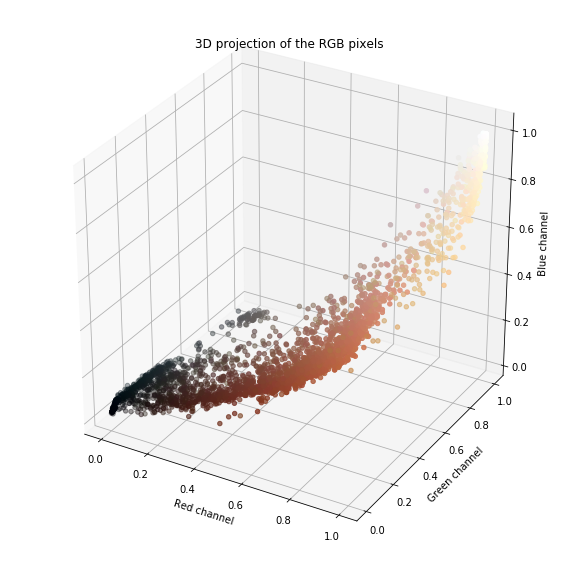

In [ ]:
"""
Now that we have the image collapsed in a list of pixels, it is possible
to display each individual pixel in 3D, just by connecting the RGB intensities
to the axis X, Y, Z.
"""
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(*pixels_small.T, color=pixels_small)
ax.set_xlabel("Red channel")
ax.set_ylabel("Green channel")
ax.set_zlabel("Blue channel")
plt.title("3D projection of the RGB pixels")
plt.show()

## Step 1: Computing distances

The first step consist of computing the euclidean distance between two sets of points.

In [ ]:
def euclidean_dist(a, b):
    """Computes the euclidean distance between two sets of D-dimensional points.

    Args:
        a (array): A list of points of shape (N, D).
        b (array): A list of points of shape (M, D).

    Returns:
        (array): An array of shape (N, M) containing all the pairwise distances between each point of a and b.
    """
    # If a or b are python lists, they are transformed into numpy arrays.
    if isinstance(a, list): a = np.array(a)
    if isinstance(b, list): b = np.array(b)
    assert a.ndim == 2 and b.ndim == 2, "a and b must be 2-dimensional arrays."
    assert a.shape[1] == b.shape[1], "a and b must have the same dimension D."

    N = a.shape[0]
    M = b.shape[0]
    D = a.shape[1]
    distances = np.ones((N, M))

    # [CODE HERE] Fill in the matrix "distances" so that it contains the pairwise distances between the point set a and b.
    # Advice: try using only two nested for-loops, for speed's sake.

    # [/CODE HERE]

    return distances

In [ ]:
# Testing the euclidean distance
assert euclidean_dist([[0]], [[1]]) == 1, "Unit test 1 failed."
assert euclidean_dist([[0, 0, 0]], [[1, 1, 1]]) == np.sqrt(3), "Unit test 2 failed."
np.random.seed(0)
random_array1 = np.random.rand(10, 4)
random_array2 = np.random.rand(10, 4)
assert np.abs(euclidean_dist(random_array1, random_array2).mean() - 0.8897) < 1e-4, "Unit test 3 failed."

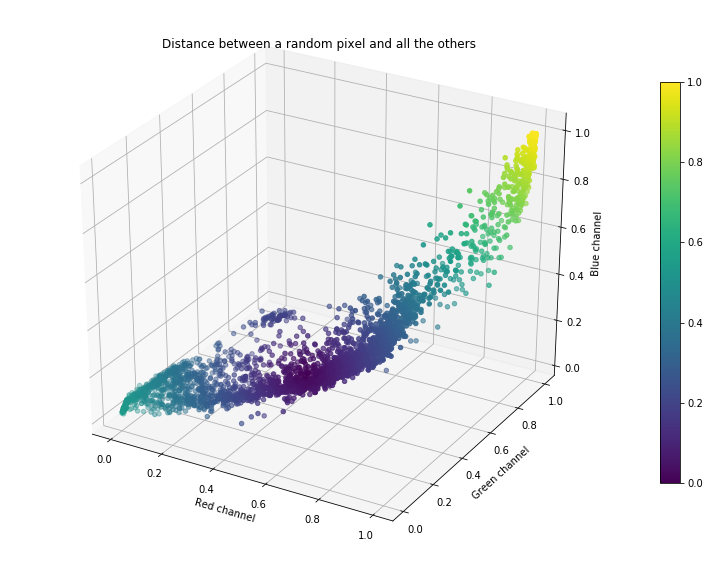

In [ ]:
# We will test the euclidean function by picking a random pixel
# and checking its distance with all the other pixels in the image.
# you can choose to modify "random_pixel" to a specific pixel or
# position in the 3D space.
N = pixels_small.shape[0]
random_index = np.random.randint(N)
random_pixel = np.array([pixels_small[random_index]])

# Computing all the distances
distances = euclidean_dist(random_pixel, pixels_small)[0]
# The distances are normalised to be between 0 and 1.
distances /= distances.max()
import mpl_toolkits.mplot3d.art3d as art3d

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(*pixels_small.T, c=distances)
fig.colorbar(p, fraction=0.03)
ax.set_xlabel("Red channel")
ax.set_ylabel("Green channel")
ax.set_zlabel("Blue channel")
plt.title("Distance between a random pixel and all the others")
plt.show()

## KMeans clustering

In [ ]:
# The following part needs to be implemented by you.
class KMeans:
    """ K-Means Algorithm. """

    def __init__(self, K, D):
        """Initialisation of the KMeans algorithm.
        Args:
            K (int): The number of clusters to use.
            D (int): The number of dimensions
        """
        self.K = K
        self.D = D
        # Initialise the clusters to zero
        self.clusters = np.zeros((K, D))

    def fit(self, data, iterations=5):
        """Trains the algorithm and iteratively refines the clusters' positions.

        Args:
            data (array): The data points to cluster, shape must be (N, D)
            iterations (int): The number of iterations of the K-means algorithm.

        Note:
            The algorithm updates the member variable "clusters".
        """
        assert data.ndim == 2 and data.shape[1] == self.D, "The data should have the shape (N, D)."
        assert iterations > 0, "The number of iterations should be positive."
        # Starting the algorithm
        N = data.shape[0] # Number of points in the data

        # [CODE HERE] Update the clusters in function of the data
        # 1. Pick K random points from the data and use them as starting position for the clusters.

        # 2. Compute the distances between the data and the clusters

        # 3. Associate each data point to the nearest cluster

        # 4. For each cluster

            # 5. Gather all the points in the cluster

            # 6. Compute the mean value of the cluster

            # 7. Update of the position of the cluster
            self.clusters[i] = mean_value
        # [/CODE HERE]

    def predict(self, data):
        """Predicts the cluster id for each of the

        Args:
            data (array): The data points to cluster, shape must be (N, D)

        Returns:
            (list of int): The id of the cluster of each of the data points, shape is N.
        """
        assert data.ndim == 2 and data.shape[1] == self.D, "The data should have the shape (N, D)."

        # [CODE HERE] Update the clusters in function of the data
        # 1. Compute the distances between data and the clusters.

        # 2. The datapoints are associated to each clusters.

        # [/CODE HERE]

        return clustered_points

In [ ]:
# Choose a number of clusters
K = 16
kmeans = KMeans(K=K, D=3)
kmeans.fit(pixels_small, iterations=30)

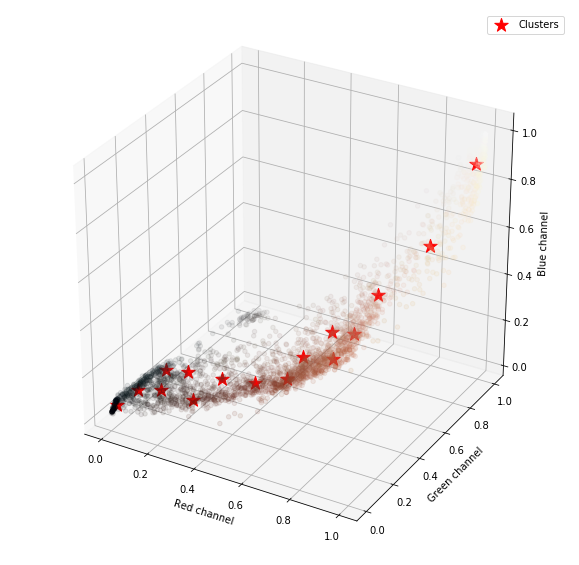

In [ ]:
"""
Again, we show the 3D projection of the RGB pixels, along with the position of the learnt clusters.
"""
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(*pixels_small.T, color=pixels_small, alpha=0.1)
ax.scatter(*kmeans.clusters.T, s=200, color="red", marker="*", depthshade=False, label="Clusters")
ax.set_xlabel("Red channel")
ax.set_ylabel("Green channel")
ax.set_zlabel("Blue channel")
plt.legend()
plt.show()

## Clustering the image

In [ ]:
# We take the original image (we dropped a lot of pixels in the beginning, remember?), as
# we will compress the full sized image.
# We already trained the kmeans algorithm by calling fit before.
# Each of the pixels of the big image is associated to a specific cluster.
clustered_image = kmeans.predict(pixels)
# We now need to determine which color is given to each cluster. In this case
# we will take the mean.
# Constructing the palette
palette = np.empty((kmeans.K, kmeans.D))
# For each cluster
for i in range(kmeans.K):
    # We take the pixels belonging to the ith cluster.
    cluster = pixels[clustered_image == i]
    # We compute the average color for the cluster
    color = cluster.mean(axis=0)
    # The ith color of the palette is set.
    palette[i] = color

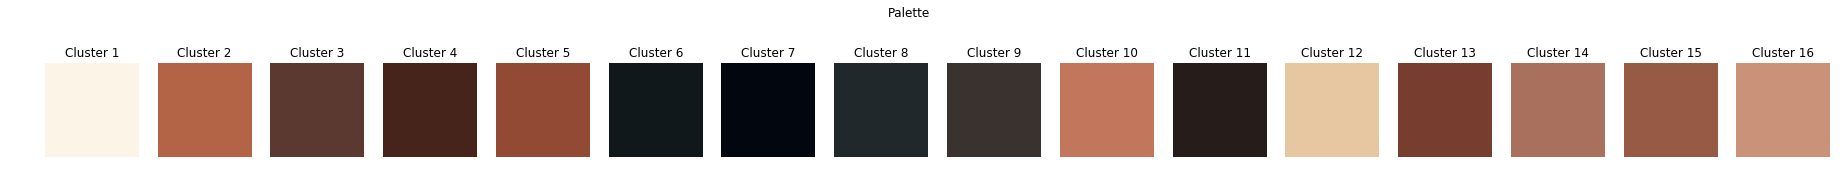

In [ ]:
fig, ax = plt.subplots(1, kmeans.K, figsize=(2*kmeans.K, 3))
fig.suptitle("Palette")
for i in range(kmeans.K):
    ax[i].set_title(f"Cluster {i+1}")
    ax[i].imshow(palette[i].reshape(1, 1, kmeans.D), interpolation="None")
    ax[i].axis("off")
plt.show()

In [ ]:
def cluster2image(image, palette, imshape):
    """Constructs an RGB image from the clustered pixels and a palette.

    Args:
        image (list of int): a list of clustered pixels, shape (N).
        palette (array): a list of K different colors.
        imshape: the 2D shape of the image to create.
    """
    assert image.ndim == 1, "The image must have only one dimension."
    assert palette.ndim == 2, "The palette must have two dimensions."
    assert isinstance(imshape, tuple), "imshape must be a tuple."

    N = image.shape[0]
    K, D = palette.shape

    final_image = np.empty((N, D))
    for i in range(K):
        cluster = image == i
        for j in range(D):
            final_image[cluster, j] = palette[i, j]

    return final_image.reshape(imshape)

In [ ]:
final_image = cluster2image(clustered_image, palette, image.shape)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title("Original image")
ax[0].imshow(image)
ax[1].set_title("Compressed image")
ax[1].imshow(final_image)
plt.show()

# Part 2 - Classification

There are many ways of finding out if a person is healthy or not, measuring the Body Mass Index (BMI) is not one of them. Even though the word "healthiness" might bring up a very clear mental image to you, it is in reality very hard to come up with a good metric to classify if a person is healthy or not. There are so many factors that must be taken into account that it becomes impossible to come up with a fair and objective score of healthiness (e.g.: environment, genetic background, sport, food consumption, drugs, diseases, etc.).

From health professionals to facebook posts, people tried to relate body measurements to an optimal weight. For instance, check out the A4 waist challenge if you want to lose faith in humanity. Anyways, a fairly common measurement used today is the one based on Body Mass Index (BMI), which is the weight of a person divided by their height squared. In this second part, we're going to measure how good or bad of a measure it is.

Now, we need to find a dataset that contains body measurements along with a ground-truth. A better measurement (there is no perfect measurement of anything) is the body fat percentage, which is the proportion of adipose tissue of a body. It is possible to translate those proportions to the following classes:
* Essential fat:  2- 5 %
* Athletes     :  6-13 %
* Fitness      : 14-17 %
* Average      : 18-24 %
* Obese        : 25+   %

Source: https://www.acefitness.org/education-and-resources/lifestyle/blog/112/what-are-the-guidelines-for-percentage-of-body-fat-loss

Those classes only apply to men, and many people do not agree with those classes. But for today's exercise it will do.

__disclaimer__: This introduction was to show you that many fields of science work with data that is:
* small (this dataset has 252 samples)
* biased (It is only men)
* imperfect (Those people come from the army, it is not a random population sample)

__Sum up__: We have data containing 252 men with their body fat percentage, alongside with body measurements. First step will be to place them into categories and find a way to predict the type of body shape from body measurements.

In [ ]:
# Source: http://staff.pubhealth.ku.dk/~tag/Teaching/share/data/Bodyfat.html
!wget -nc http://staff.pubhealth.ku.dk/~tag/Teaching/share/data/Bodyfat.csv

--2020-02-21 07:42:34--  http://staff.pubhealth.ku.dk/~tag/Teaching/share/data/Bodyfat.csv
Resolving staff.pubhealth.ku.dk (staff.pubhealth.ku.dk)... 192.38.117.59
Connecting to staff.pubhealth.ku.dk (staff.pubhealth.ku.dk)|192.38.117.59|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18916 (18K) [text/csv]
Saving to: ‘Bodyfat.csv’

Bodyfat.csv         100%[===================>]  18.47K  --.-KB/s    in 0.1s    

2020-02-21 07:42:35 (178 KB/s) - ‘Bodyfat.csv’ saved [18916/18916]



In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

In [ ]:
df = pd.read_csv("Bodyfat.csv")
# Documentation: https://en.wikipedia.org/wiki/Pound_(mass)
# [CODE HERE] Converting weight from pounds to kilos

# [/CODE HERE]
assert np.abs(df.Weight.mean() - 81.159) < 1e-3, "The weight conversion to kg is wrong."

# Documentation: https://en.wikipedia.org/wiki/Inch
# [CODE HERE] Converting height from inches to cm

# [/CODE HERE]
assert np.abs(df.Height.mean() - 178.178) < 1e-3, "The height conversion to cm is wrong."
# Shuffle the dataset
df = df.sample(frac=1, random_state=0)
df.head()

Density  bodyfat  Age     Weight  ...  Ankle  Biceps  Forearm  Wrist
158   1.0704     12.5   30  61.915359  ...   21.8    27.0     34.9   16.9
83    1.0377     27.0   70  77.450897  ...   24.1    31.2     27.3   19.2
170   1.0926      3.0   35  69.059438  ...   22.1    30.4     27.4   17.7
101   1.0524     20.4   48  78.811674  ...   22.4    27.9     26.2   17.0
150   1.0776      9.4   26  69.059438  ...   20.4    31.6     29.0   17.8

[5 rows x 15 columns]

In [ ]:
# Source: https://www.acefitness.org/education-and-resources/lifestyle/blog/112/what-are-the-guidelines-for-percentage-of-body-fat-loss
# Essential fat: (-∞,  6) %
# Athletes     : [ 6, 14) %
# Fitness      : [14, 18) %
# Average      : [18, 25) %
# Obese        : [25, +∞) %
classes = ["Essential fat", "Athletes", "Fitness", "Average", "Obese"]
C = len(classes)

N = df.shape[0]
# [CODE HERE] Create a variable "y" containing labels from 0 to 4 for each class above, depending on the variable bodyfat.
# Example: if the body fat is 22.4, then the associated class should be 3.

# [/CODE HERE]

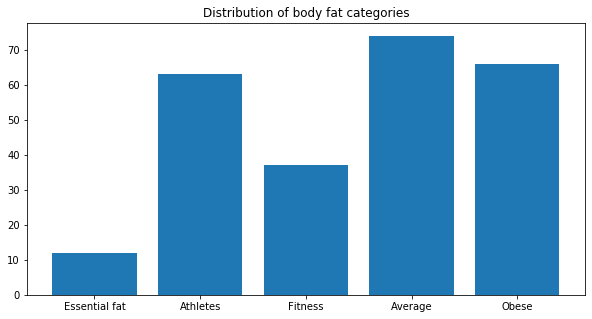

In [ ]:
assert len(y) == len(df), "The length of y should be the same length as X"
assert (np.unique(y) == np.arange(C)).all(), "There should be only 5 classes, from 0 to 4"
assert np.sum(y == 0) == 12, "The number of times class 0 appears is wrong."
assert np.sum(y == 1) == 63, "The number of times class 1 appears is wrong."
assert np.sum(y == 2) == 37, "The number of times class 2 appears is wrong."
assert np.sum(y == 3) == 74, "The number of times class 3 appears is wrong."
assert np.sum(y == 4) == 66, "The number of times class 4 appears is wrong."

plt.figure(figsize=(10, 5))
plt.title("Distribution of body fat categories")
hist, bins = np.histogram(y, bins=np.arange(C+1))
plt.bar(classes, hist)
plt.show()

In [ ]:
X = df.drop(columns=["bodyfat", "Density"])
X.describe()

Age      Weight      Height  ...      Biceps     Forearm       Wrist
count  252.000000  252.000000  252.000000  ...  252.000000  252.000000  252.000000
mean    44.884921   81.158745  178.177976  ...   32.273413   28.663889   18.229762
std     12.602040   13.330699    9.303654  ...    3.021274    2.020691    0.933585
min     22.000000   53.750696   74.930000  ...   24.800000   21.000000   15.800000
25%     35.750000   72.121187  173.355000  ...   30.200000   27.300000   17.600000
50%     43.000000   80.059053  177.800000  ...   32.050000   28.700000   18.300000
75%     54.000000   89.357697  183.515000  ...   34.325000   30.000000   18.800000
max     81.000000  164.722069  197.485000  ...   45.000000   34.900000   21.400000

[8 rows x 13 columns]

# Testing different models on a train set

In [ ]:
def train_and_test(algorithm, X_train, y_train, X_test=None, y_test=None):
    """This function takes a given algorithm, trains in on some data, and returns the F1-score

    Args:
        algorithm (sklearn model): A model to train.
        X_train (array): The input variables to train on.
        y_train (array): The variable to predict (training set).
        X_test (array): (optional) The input variables to test on.
        y_test (array): (optional) The variable to predict (testing set).

    Returns:
        float: The f1-score of the method.

    Note:
        If X_test is not provided, the training set is used for testing.
    """
    if X_test is None:
        X_test, y_test = X_train, y_train
    algorithm.fit(X_train, y_train)
    y_pred = algorithm.predict(X_test)
    return f1_score(y_test, y_pred, average="micro")

In [ ]:
# Documentation:
# * https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
# * https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
# [CODE HERE] Using the train_and_test function, compute the F1-score for the Logistic regression,
# a Support Vector Classifier with a linear kernel, and a Support Vector Classifier with an rbf kernel.
# For now, do not use a test set, leave the parameters X_test and y_test equal to None.
# Logistic regression

print(f"Logistic regression score: {f1:.3f}") # Should be approx. 0.63
# SVC (linear kernel)

print(f"Linear SVC score: {f1:.3f}") # Should be approx. 0.69
# SVC (rbf kernel)

print(f"RBF SVC score: {f1:.3f}") # Should be approx 1.00
# [/CODE HERE]

F1-scores of different models:
      LogReg: 0.631
  SVC-Linear: 0.690
     SVC-RBF: 1.000


Oh great! Look at that! If everything went well you should get a whopping 100% of F1-score.

Too good to be true? Unfortunately, the Radial Based Function (RBF) kernel is __really__ powerful and completely overfits the data. We need a test set, that the model has never seen to check if it can generalise to new data.

## Testing on a real test set (KFold)

It is possible to split the data in two subsets: a training set and a testing set. In our case, we have little information, so removing 20% of the dataset to keep as a test set is costly. More, we could just be lucky/unlucky during a run and get extremely good/bad results by chance.

One way of solving this issue is by using a method called K-fold cross-validation. The goal is to separate the data in K buckets, let's say 10 buckets. Now, we can train a model on 9 buckets and keep 1 for testing. We can even repeat this experiment with 10 models which will all see different buckets.

More information: https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29

Scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [ ]:
def train_and_test_kfold(algorithm, X, y, kf):
    """This function takes a given algorithm, trains in on some data, and returns the F1-score

    Args:
        algorithm (sklearn model): A model to train.
        X (array): The input variables to use for K-Folding.
        y (array): The variable to predict for K-Folding.
        kf (KFold): A Kfold cross validator.

    Returns:
        float: The list of f1 scores for each of the k-folds.
    """
    scores = []
    # Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    # [CODE HERE] Implement the KFold from kf
    # For each kfolds

        # Compute the score for the said buckets

        # Append the f1 score to the list of scores
        scores.append(f1)
    # [/CODE HERE]
    assert len(scores) == kf.n_splits, "The number of scores must be equal to the number of k-fold buckets."
    return np.array(scores)

F1-scores of different models (KFold size=10):
      LogReg: 0.568 ± 0.106
  SVC-Linear: 0.577 ± 0.089
     SVC-RBF: 0.275 ± 0.056


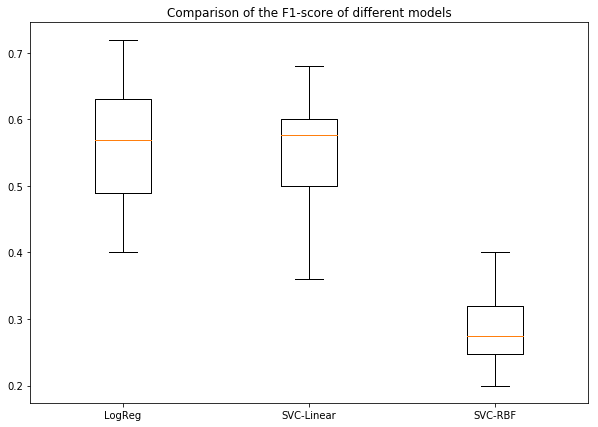

In [ ]:
models = [
    LogisticRegression(),
    SVC(kernel="linear"),
    SVC(kernel="rbf")
]
model_names = [
    "LogReg",
    "SVC-Linear",
    "SVC-RBF"
]

kf = KFold(n_splits=10)
print(f"F1-scores of different models (KFold size={kf.n_splits}):")
scores = []
for model, name in zip(models, model_names):
    f1 = train_and_test_kfold(model, X, y, kf)
    scores.append(f1)
    print(f"{name: >12}: {np.median(f1):.3f} ± {f1.std(ddof=1):.3f}")

plt.figure(figsize=(10, 7))
plt.title("Comparison of the F1-score of different models")
plt.boxplot(scores, labels=model_names)
plt.show()

## Adding existing models (Is BMI a garbage measurement?)
We will implement three new models, with transformed input data.

* The first model: We will be checking if the BMI is a good measure.
You can check on wikipedia (https://en.wikipedia.org/wiki/Body_mass_index) what the formula is and implement it below. __Be careful__: the height in the dataset is in centimeters.

* The second model: We will check how a more complex formula from the US army is performing. Please refer to: https://www.ncbi.nlm.nih.gov/books/NBK235939/ where the table 4-5a contains the formula.

* The third model: The previous model from the army contains some logarithms. Would log-transforming the data improve our model? What if we need both the regular data and log-data? Let's try it too.

In [ ]:
# [CODE HERE] Create a pandas series named X_BMI that contains the BMI of each adult in the dataset.
# [/CODE HERE]
X_BMI = X_BMI.to_frame()

# [CODE HERE] Create a pandas series named X_army that contains the army model of each adult in the dataset.
# [/CODE HERE]
X_army = X_army.to_frame()

# This one is already done, adding the log-data to the regular data (column-wise)
X_log10 = pd.concat([X, np.log10(X).add_suffix("_log10")], axis=1)

F1-scores of different models (KFold size=10):
      LogReg: 0.568 ± 0.106
  SVC-Linear: 0.577 ± 0.089
     SVC-RBF: 0.275 ± 0.056
         BMI: 0.540 ± 0.062
        Army: 0.628 ± 0.079
       log10: 0.588 ± 0.095


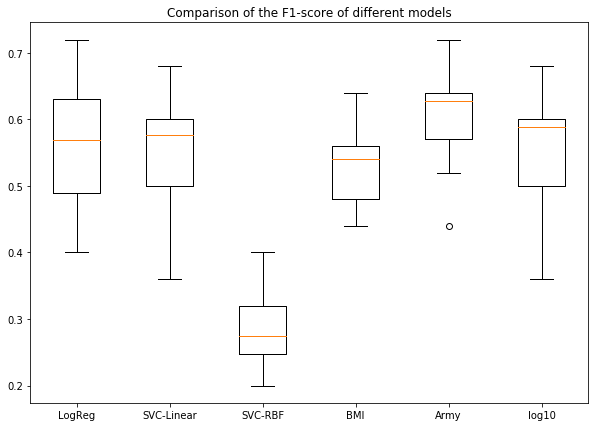

In [ ]:
# Normal models again (we use them to compare)
models = [
    LogisticRegression(),
    SVC(kernel="linear"),
    SVC(kernel="rbf")
]
model_names = [
    "LogReg",
    "SVC-Linear",
    "SVC-RBF"
]

# Old models
kf = KFold(n_splits=10)
print(f"F1-scores of different models (KFold size={kf.n_splits}):")
scores = []
for model, name in zip(models, model_names):
    f1 = train_and_test_kfold(model, X, y, kf)
    scores.append(f1)
    print(f"{name: >12}: {np.median(f1):.3f} ± {f1.std(ddof=1):.3f}")
# New models
model_names.extend([
    "BMI",
    "Army",
    "log10",
])
for i, dataset in enumerate([X_BMI, X_army, X_log10]):
    f1 = train_and_test_kfold(SVC(kernel="linear"), dataset, y, kf)
    scores.append(f1)
    print(f"{model_names[3+i]: >12}: {np.median(f1):.3f} ± {f1.std(ddof=1):.3f}")

plt.figure(figsize=(10, 7))
plt.title("Comparison of the F1-score of different models")
plt.boxplot(scores, labels=model_names)
plt.show()

## Questions
If everything went well, the Support Vector Classifier with the RBF kernel is the worst one because it is overfitting, so let's exclude it from the results.

1. Which is the worst method overall?
2. Which is the best method?
3. What could you do to improve the classification accuracy?
4. How does the BMI compare to the US Army way of measuring healthiness?
5. What is your best result, are you happy with such a classifier?